# Hardware-Aware SNN for Parkinson's Disease Detection
## Memristor Weight Quantization: Simulating Hardware Constraints

Hardware-Aware SNN Feasibility Study

This notebook implements a hardware-aware Spiking Neural Network that simulates memristor weight constraints:
- **Realistic conductance mapping**: Weights quantized to [g_min, g_max] range
- **Discrete quantization**: 256 levels (8-bit precision)
- **Hardware constraints**: r_on=1kΩ, r_off=10kΩ (10:1 ratio)
- **Accuracy trade-off**: Measuring performance degradation vs baseline
- **Transparent methodology**: Weight-level simulation, not full crossbar

## 1. Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import sys
from datetime import datetime
from scipy import signal
import joblib
import copy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)
from sklearn.preprocessing import StandardScaler, RobustScaler

# Add modules to path
sys.path.append(str(Path.cwd() / 'modules'))
from modules.path_module import *
from modules.feature_extraction import *
from modules.processing_module import *
from modules.snn_models import *

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Random seed for reproducibility
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Random seed: {RANDOM_SEED}")
print(f"\nSetup complete!")

Using device: cpu
Random seed: 123

Setup complete!


## 2. Data Preparation

In [2]:
# Load feature configuration (same as snn_aware_baseline_classifier - 28 features)
config_path = Path('results/snn/optimal_feature_config_comprehensive.json')
with open(config_path, 'r') as f:
    feature_config = json.load(f)

print(f"Feature Configuration:")
print(f"  Type: {feature_config['type']}")
print(f"  Number of features: {feature_config['n_features']}")

# Load processed EEG data
print("Loading processed EEG data...")
processed_path = processed_datapath()
train_data = joblib.load(processed_path / 'train_data.pkl')
val_data = joblib.load(processed_path / 'val_data.pkl')
test_data = joblib.load(processed_path / 'test_data.pkl')

print(f"  Train: {len(train_data)} segments")
print(f"  Val:   {len(val_data)} segments")
print(f"  Test:  {len(test_data)} segments")

# Extract features using the same configuration as baseline
X_train_raw, y_train, _ = extract_features_from_dataset(
    train_data,
    feature_config=feature_config,
    feature_type='enhanced'  
)
X_val_raw, y_val, _ = extract_features_from_dataset(
    val_data,
    feature_config=feature_config,
    feature_type='enhanced'  
)
X_test_raw, y_test, _ = extract_features_from_dataset(
    test_data,
    feature_config=feature_config,
    feature_type='enhanced'  
)

print(f"\nFeature shapes:")
print(f"  Train: {X_train_raw.shape}")
print(f"  Val:   {X_val_raw.shape}")
print(f"  Test:  {X_test_raw.shape}")

print(f"\nClass distribution (Test set):")
print(f"  Control: {np.sum(y_test == 0)}")
print(f"  PD:      {np.sum(y_test == 1)}")

# Normalize features (StandardScaler)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nData preparation complete!")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

Feature Configuration:
  Type: selected_channel_bands_comprehensive
  Number of features: 28
Loading processed EEG data...
  Train: 384 segments
  Val:   120 segments
  Test:  156 segments

Feature shapes:
  Train: (384, 28)
  Val:   (120, 28)
  Test:  (156, 28)

Class distribution (Test set):
  Control: 72
  PD:      84

Data preparation complete!
  Batch size: 32
  Train batches: 12
  Test batches: 5


# Loading baseline model

In [ ]:
# Load the  baseline model
baseline_model = SNN(
    num_features=28,
    num_classes=2,
    num_steps=35,
    hidden1_size=56,
    hidden2_size=42,
    dropout=0.4
).to(device)

model_path = Path('results/snn/two_layer_28features_model.pth')
baseline_model.load_state_dict(torch.load(model_path, map_location=device))
baseline_model.eval()

print(" Loaded trained baseline model from:", model_path)

 Loaded trained baseline model from: results\snn\two_layer_28features_model.pth


## 4. Evaluate Baseline SNN Performance

In [4]:
def evaluate_model(model, data_loader, threshold=0.5):
    """Evaluate model on dataset."""
    model.eval()
    all_labels = []
    all_preds = []
    all_scores = []
    all_outputs = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            spk_rec, mem_rec = model(data)
            outputs = mem_rec.mean(0)  # Temporal averaging

            probs = torch.softmax(outputs, dim=1)
            scores = probs[:, 1].cpu().numpy()  # PD probability
            preds = (scores >= threshold).astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_scores.extend(scores)
            all_outputs.append(outputs.cpu())

    all_outputs = torch.cat(all_outputs, dim=0)
    return np.array(all_labels), np.array(all_preds), np.array(all_scores), all_outputs


def compute_metrics(labels, preds, scores):
    """Compute comprehensive metrics."""
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'sensitivity': recall_score(labels, preds, pos_label=1, zero_division=0),
        'specificity': recall_score(labels, preds, pos_label=0, zero_division=0),
        'f1_score': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, scores) if len(np.unique(labels)) > 1 else 0.0
    }


# Evaluate baseline model to get predictions for comparison
print("Evaluating Baseline SNN (for comparison)...")
y_true_baseline, y_pred_baseline, y_scores_baseline, outputs_baseline = evaluate_model(
    baseline_model, test_loader, threshold=0.5
)

# Compute baseline metrics from actual evaluation (not from saved JSON)
baseline_metrics = compute_metrics(y_true_baseline, y_pred_baseline, y_scores_baseline)

print(f"\nBaseline SNN Performance (freshly evaluated):")
print(f"  Accuracy:    {baseline_metrics['accuracy']*100:.2f}%")
print(f"  Sensitivity: {baseline_metrics['sensitivity']*100:.2f}%")
print(f"  Specificity: {baseline_metrics['specificity']*100:.2f}%")
print(f"  F1-Score:    {baseline_metrics['f1_score']*100:.2f}%")
print(f"  AUC:         {baseline_metrics['auc']:.4f}")

Evaluating Baseline SNN (for comparison)...

Baseline SNN Performance (freshly evaluated):
  Accuracy:    84.62%
  Sensitivity: 84.52%
  Specificity: 84.72%
  F1-Score:    85.54%
  AUC:         0.9033


## 5. Hardware-Aware SNN with Memristor Weight Quantization

In [5]:
class HardwareAwareSNN(nn.Module):
    """
    SNN with simulated memristor weight quantization.
    """
    
    def __init__(self, baseline_snn, r_on=1000, r_off=10000, num_levels=256):
        super().__init__()
        # Deep copy to preserve baseline
        self.snn = copy.deepcopy(baseline_snn)
        
        # Memristor parameters
        self.r_on = r_on
        self.r_off = r_off
        self.g_min = 1.0 / r_off  # Minimum conductance
        self.g_max = 1.0 / r_on   # Maximum conductance
        self.num_levels = num_levels
        
        # Quantize weights
        self._apply_hardware_constraints()
    
    def _apply_hardware_constraints(self):
        """Quantize all SNN weights to memristor conductance levels."""
        
        for name, module in self.snn.named_modules():
            if isinstance(module, nn.Linear):
                with torch.no_grad():
                    original_weights = module.weight.data.clone()
                    
                    # Step 1: Normalize weights to [0, 1]
                    w_min = original_weights.min()
                    w_max = original_weights.max()
                    w_normalized = (original_weights - w_min) / (w_max - w_min + 1e-10)
                    
                    # Step 2: Map to conductance range [g_min, g_max]
                    conductances = self.g_min + w_normalized * (self.g_max - self.g_min)
                    
                    # Step 3: Quantize to discrete levels
                    g_norm = (conductances - self.g_min) / (self.g_max - self.g_min)
                    g_quantized_norm = torch.round(g_norm * (self.num_levels - 1)) / (self.num_levels - 1)
                    conductances_quantized = self.g_min + g_quantized_norm * (self.g_max - self.g_min)
                    
                    # Step 4: Convert back to weight values
                    w_normalized_quant = (conductances_quantized - self.g_min) / (self.g_max - self.g_min)
                    quantized_weights = w_min + w_normalized_quant * (w_max - w_min)
                    
                    # Step 5: Replace weights
                    module.weight.data = quantized_weights
                    
                    # Report quantization impact
                    diff = (original_weights - quantized_weights).abs().mean().item()
                    print(f"  {name:10s}: Shape {tuple(module.weight.shape)}, "
                          f"Quantization error = {diff:.6f}")
    
    def forward(self, x):
        """Forward pass through quantized SNN."""
        return self.snn(x)

# Memristor configuration
memristor_config = {
    'r_on': 1000,           # 1 kOhm (high conductance state)
    'r_off': 10000,         # 10 kOhm (low conductance state)
    'ratio': 10,            # r_off / r_on
    'num_levels': 256       # 8-bit quantization
}

print(f"Memristor Configuration:")
print(f"  r_on:  {memristor_config['r_on']:,} Ohm (high conductance)")
print(f"  r_off: {memristor_config['r_off']:,} Ohm (low conductance)")
print(f"  Resistance ratio: {memristor_config['ratio']}:1")
print(f"  Quantization levels: {memristor_config['num_levels']} (8-bit precision)")

g_min = 1.0 / memristor_config['r_off']
g_max = 1.0 / memristor_config['r_on']
print(f"  Conductance range: [{g_min:.2e}, {g_max:.2e}] Siemens")

Memristor Configuration:
  r_on:  1,000 Ohm (high conductance)
  r_off: 10,000 Ohm (low conductance)
  Resistance ratio: 10:1
  Quantization levels: 256 (8-bit precision)
  Conductance range: [1.00e-04, 1.00e-03] Siemens


In [6]:
# Create hardware-aware SNN with memristor constraints
print("Creating Hardware-Aware SNN...")
hardware_snn = HardwareAwareSNN(
    baseline_snn=baseline_model,
    r_on=memristor_config['r_on'],
    r_off=memristor_config['r_off'],
    num_levels=memristor_config['num_levels']
)

hardware_snn.eval()

# Count total "memristors" (quantized weights)
total_memristors = 0
for name, module in hardware_snn.snn.named_modules():
    if isinstance(module, nn.Linear):
        num_weights = module.in_features * module.out_features
        total_memristors += num_weights

print(f"\nHardware-Aware SNN Summary:")
print(f"  Total quantized weights (memristors): {total_memristors:,}")
print(f"  Architecture: 28 → 56 → 42 → 2")
print(f"  Quantization: 8-bit ({memristor_config['num_levels']} levels)")

# Verify quantization worked (weights should be different from baseline)
print(f"\n{'='*70}")
print(f"  VERIFICATION: Weight Quantization Check")
print(f"{'='*70}")

baseline_w = baseline_model.fc1.weight.detach().cpu()
hardware_w = hardware_snn.snn.fc1.weight.detach().cpu()

print(f"\nLayer fc1 (28 → 56):")
print(f"  Baseline weights [0,0:5]:  {baseline_w[0, :5]}")
print(f"  Hardware weights [0,0:5]:  {hardware_w[0, :5]}")
print(f"  Weights identical? {torch.allclose(baseline_w, hardware_w)}")
print(f"  Mean absolute difference: {(baseline_w - hardware_w).abs().mean():.6f}")

# Check if discrete quantization is visible
unique_vals = len(torch.unique(hardware_w))
print(f"  Unique weight values (baseline): {len(torch.unique(baseline_w)):,}")
print(f"  Unique weight values (hardware): {unique_vals:,}")
print(f"  Expected max unique values: {memristor_config['num_levels']}")

Creating Hardware-Aware SNN...
  fc1       : Shape (56, 28), Quantization error = 0.000397
  fc2       : Shape (42, 56), Quantization error = 0.000319
  fc_out    : Shape (2, 42), Quantization error = 0.000350

Hardware-Aware SNN Summary:
  Total quantized weights (memristors): 4,004
  Architecture: 28 → 56 → 42 → 2
  Quantization: 8-bit (256 levels)

  VERIFICATION: Weight Quantization Check

Layer fc1 (28 → 56):
  Baseline weights [0,0:5]:  tensor([-0.0567, -0.0170, -0.1030,  0.0410, -0.1560])
  Hardware weights [0,0:5]:  tensor([-0.0565, -0.0164, -0.1030,  0.0413, -0.1560])
  Weights identical? False
  Mean absolute difference: 0.000397
  Unique weight values (baseline): 1,568
  Unique weight values (hardware): 232
  Expected max unique values: 256


## 6. Evaluate Hardware-Aware SNN Performance

In [7]:
# Evaluate hardware-aware SNN
print("Evaluating Hardware-Aware SNN on test set...")
y_true_hw, y_pred_hw, y_scores_hw, outputs_hw = evaluate_model(
    hardware_snn, test_loader, threshold=0.5
)
hardware_metrics = compute_metrics(y_true_hw, y_pred_hw, y_scores_hw)

Evaluating Hardware-Aware SNN on test set...


## Segment level confusion matrix

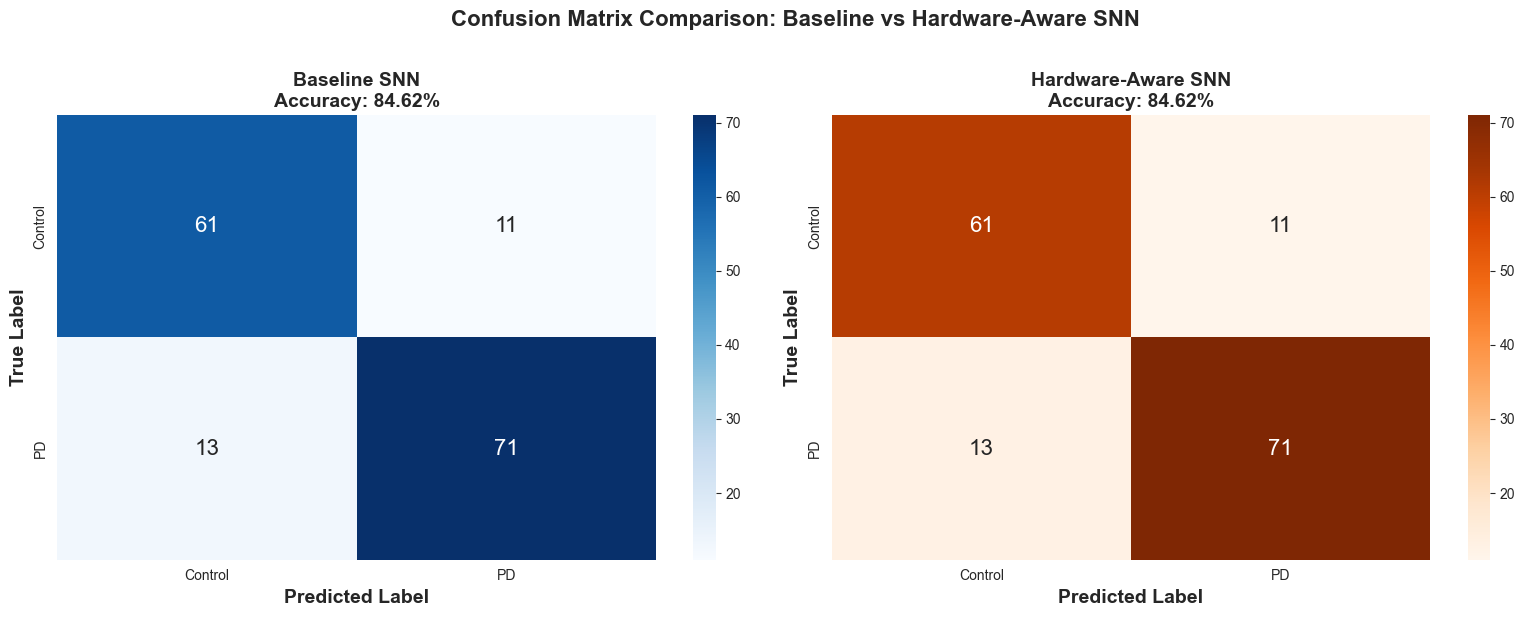

In [8]:
# Create side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline confusion matrix
cm_baseline = confusion_matrix(y_true_baseline, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Control', 'PD'], yticklabels=['Control', 'PD'], 
            ax=axes[0], annot_kws={'size': 16})
axes[0].set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=14, fontweight='bold')
axes[0].set_title(f'Baseline SNN\nAccuracy: {baseline_metrics["accuracy"]*100:.2f}%', 
                  fontsize=14, fontweight='bold')

# Hardware-aware confusion matrix
cm_hardware = confusion_matrix(y_true_hw, y_pred_hw)
sns.heatmap(cm_hardware, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Control', 'PD'], yticklabels=['Control', 'PD'], 
            ax=axes[1], annot_kws={'size': 16})
axes[1].set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=14, fontweight='bold')
axes[1].set_title(f'Hardware-Aware SNN\nAccuracy: {hardware_metrics["accuracy"]*100:.2f}%', 
                  fontsize=14, fontweight='bold')

plt.suptitle('Confusion Matrix Comparison: Baseline vs Hardware-Aware SNN', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



In [ ]:
def evaluate_patient_level(model, test_data, device, scaler, feature_config):
    """
    Evaluate at patient level (not segment level).
    Returns metrics, labels, predictions, and scores for ROC curve.
    """
    from modules.feature_extraction import extract_all_features_enhanced
    
    model.eval()
    
    # Get unique patients
    test_patients = get_unique_patients(test_data)
    
    patient_correct = 0
    patient_predictions = []
    patient_labels = []
    patient_scores = []
    
    for patient_id in test_patients:
        # Get all segments for this patient
        patient_segments = reconstruct_patient(test_data, patient_id)
        true_label = patient_segments[0].label
        
        # Extract features and predict for each segment
        segment_probs = []
        for seg in patient_segments:
            # Extract all enhanced features (band power + entropy)
            all_features, _ = extract_all_features_enhanced(seg.data)
            
            # Select only optimal features (using config indices)
            selected_features = all_features[feature_config['selected_indices']]
            
            # Normalize
            features_scaled = scaler.transform([selected_features])
            features_tensor = torch.FloatTensor(features_scaled).to(device)
            
            # Predict
            with torch.no_grad():
                spk_rec, mem_rec = model(features_tensor)
                outputs = mem_rec.mean(0)  # Temporal averaging
                probs = torch.softmax(outputs, dim=1)
                segment_probs.append(probs.cpu().numpy()[0])
        
        # Aggregate: Average probability across all segments
        avg_prob = np.mean(segment_probs, axis=0)
        pred_label = np.argmax(avg_prob)
        confidence = avg_prob[pred_label]
        
        # Check if correct
        correct = (pred_label == true_label)
        if correct:
            patient_correct += 1
        
        patient_predictions.append(pred_label)
        patient_labels.append(true_label)
        patient_scores.append(avg_prob[1])  # PD probability
    
    # Calculate patient-level metrics
    patient_acc = patient_correct / len(test_patients)
    patient_metrics = compute_metrics(
        np.array(patient_labels), 
        np.array(patient_predictions), 
        np.array(patient_scores)
    )
    
    # Return scores as well for ROC curve
    return patient_metrics, np.array(patient_labels), np.array(patient_predictions), np.array(patient_scores)


# Evaluate baseline SNN at patient level

print("\nEvaluating Baseline SNN at patient level...")
baseline_patient_metrics, baseline_patient_labels, baseline_patient_preds, baseline_patient_scores = evaluate_patient_level(
    baseline_model, test_data, device, scaler, feature_config
)

# Evaluate hardware-aware SNN at patient level
print("\nEvaluating Hardware-Aware SNN at patient level...")
hardware_patient_metrics, hardware_patient_labels, hardware_patient_preds, hardware_patient_scores = evaluate_patient_level(
    hardware_snn, test_data, device, scaler, feature_config
)

cm_baseline_patient = confusion_matrix(baseline_patient_labels, baseline_patient_preds)
cm_hardware_patient = confusion_matrix(hardware_patient_labels, hardware_patient_preds)

print("\n" + "-"*80)
print("BASELINE SNN")
print("-"*80)
print(f"{'Metric':<20} {'Segment-Level':<18} {'Patient-Level':<18} {'Difference':<15}")
print("-"*80)
print(f"{'Accuracy':<20} {baseline_metrics['accuracy']*100:>6.2f}%{'':<11} {baseline_patient_metrics['accuracy']*100:>6.2f}%{'':<11} {(baseline_patient_metrics['accuracy'] - baseline_metrics['accuracy'])*100:+6.2f}%")
print(f"{'Sensitivity':<20} {baseline_metrics['sensitivity']*100:>6.2f}%{'':<11} {baseline_patient_metrics['sensitivity']*100:>6.2f}%{'':<11} {(baseline_patient_metrics['sensitivity'] - baseline_metrics['sensitivity'])*100:+6.2f}%")
print(f"{'Specificity':<20} {baseline_metrics['specificity']*100:>6.2f}%{'':<11} {baseline_patient_metrics['specificity']*100:>6.2f}%{'':<11} {(baseline_patient_metrics['specificity'] - baseline_metrics['specificity'])*100:+6.2f}%")
print(f"{'F1-Score':<20} {baseline_metrics['f1_score']*100:>6.2f}%{'':<11} {baseline_patient_metrics['f1_score']*100:>6.2f}%{'':<11} {(baseline_patient_metrics['f1_score'] - baseline_metrics['f1_score'])*100:+6.2f}%")
print(f"{'AUC':<20} {baseline_metrics['auc']:>6.4f}{'':<12} {baseline_patient_metrics['auc']:>6.4f}{'':<12} {(baseline_patient_metrics['auc'] - baseline_metrics['auc']):+6.4f}")

print("\n" + "-"*80)
print("HARDWARE-AWARE SNN")
print("-"*80)
print(f"{'Metric':<20} {'Segment-Level':<18} {'Patient-Level':<18} {'Difference':<15}")
print("-"*80)
print(f"{'Accuracy':<20} {hardware_metrics['accuracy']*100:>6.2f}%{'':<11} {hardware_patient_metrics['accuracy']*100:>6.2f}%{'':<11} {(hardware_patient_metrics['accuracy'] - hardware_metrics['accuracy'])*100:+6.2f}%")
print(f"{'Sensitivity':<20} {hardware_metrics['sensitivity']*100:>6.2f}%{'':<11} {hardware_patient_metrics['sensitivity']*100:>6.2f}%{'':<11} {(hardware_patient_metrics['sensitivity'] - hardware_metrics['sensitivity'])*100:+6.2f}%")
print(f"{'Specificity':<20} {hardware_metrics['specificity']*100:>6.2f}%{'':<11} {hardware_patient_metrics['specificity']*100:>6.2f}%{'':<11} {(hardware_patient_metrics['specificity'] - hardware_metrics['specificity'])*100:+6.2f}%")
print(f"{'F1-Score':<20} {hardware_metrics['f1_score']*100:>6.2f}%{'':<11} {hardware_patient_metrics['f1_score']*100:>6.2f}%{'':<11} {(hardware_patient_metrics['f1_score'] - hardware_metrics['f1_score'])*100:+6.2f}%")
print(f"{'AUC':<20} {hardware_metrics['auc']:>6.4f}{'':<12} {hardware_patient_metrics['auc']:>6.4f}{'':<12} {(hardware_patient_metrics['auc'] - hardware_metrics['auc']):+6.4f}")



Evaluating Baseline SNN at patient level...

Evaluating Hardware-Aware SNN at patient level...

--------------------------------------------------------------------------------
BASELINE SNN
--------------------------------------------------------------------------------
Metric               Segment-Level      Patient-Level      Difference     
--------------------------------------------------------------------------------
Accuracy              84.62%             84.62%             +0.00%
Sensitivity           84.52%             85.71%             +1.19%
Specificity           84.72%             83.33%             -1.39%
F1-Score              85.54%             85.71%             +0.17%
AUC                  0.9033             0.9762             +0.0729

--------------------------------------------------------------------------------
HARDWARE-AWARE SNN
--------------------------------------------------------------------------------
Metric               Segment-Level      Patient-Level  

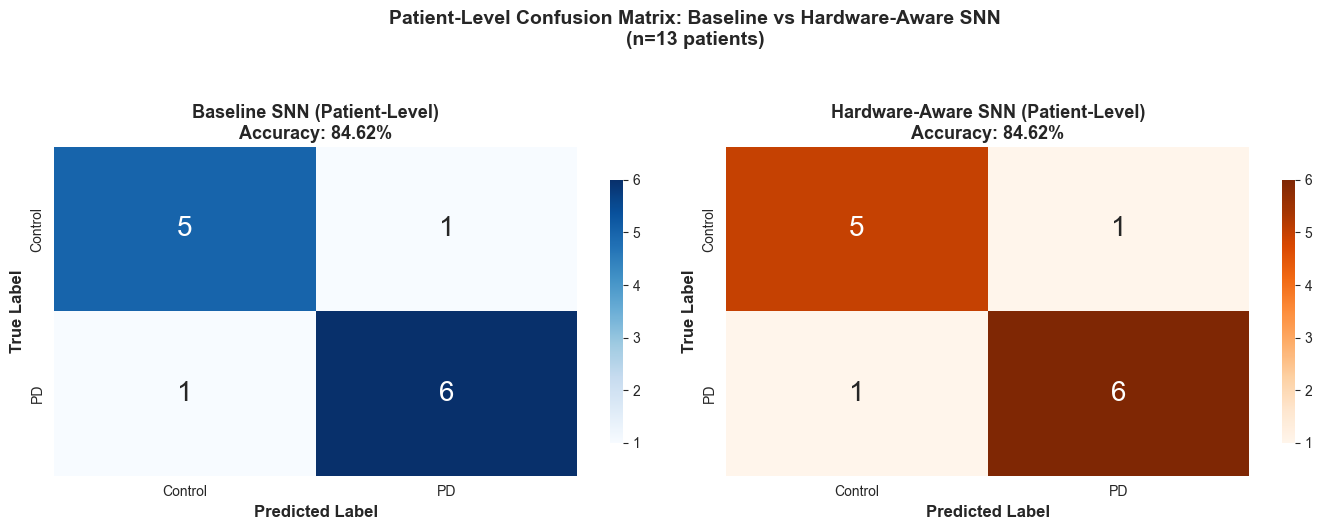


Patient-Level Summary:
  Total patients: 13
  Control: 6, PD: 7
  Baseline correctly classified: 11/13
  Hardware correctly classified: 11/13


In [10]:
# Patient-level confusion matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline patient-level confusion matrix
sns.heatmap(cm_baseline_patient, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Control', 'PD'], yticklabels=['Control', 'PD'], 
            ax=axes[0], annot_kws={'size': 20}, cbar_kws={'shrink': 0.8})
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title(f'Baseline SNN (Patient-Level)\nAccuracy: {baseline_patient_metrics["accuracy"]*100:.2f}%', 
                  fontsize=13, fontweight='bold')

# Hardware-aware patient-level confusion matrix
sns.heatmap(cm_hardware_patient, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Control', 'PD'], yticklabels=['Control', 'PD'], 
            ax=axes[1], annot_kws={'size': 20}, cbar_kws={'shrink': 0.8})
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title(f'Hardware-Aware SNN (Patient-Level)\nAccuracy: {hardware_patient_metrics["accuracy"]*100:.2f}%', 
                  fontsize=13, fontweight='bold')

plt.suptitle('Patient-Level Confusion Matrix: Baseline vs Hardware-Aware SNN\n(n=13 patients)', 
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

# Print summary
n_patients = len(baseline_patient_labels)
n_control = sum(1 for l in baseline_patient_labels if l == 0)
n_pd = sum(1 for l in baseline_patient_labels if l == 1)
print(f"\nPatient-Level Summary:")
print(f"  Total patients: {n_patients}")
print(f"  Control: {n_control}, PD: {n_pd}")
print(f"  Baseline correctly classified: {cm_baseline_patient[0,0] + cm_baseline_patient[1,1]}/{n_patients}")
print(f"  Hardware correctly classified: {cm_hardware_patient[0,0] + cm_hardware_patient[1,1]}/{n_patients}")

## 7. Weight Quantization Visualization

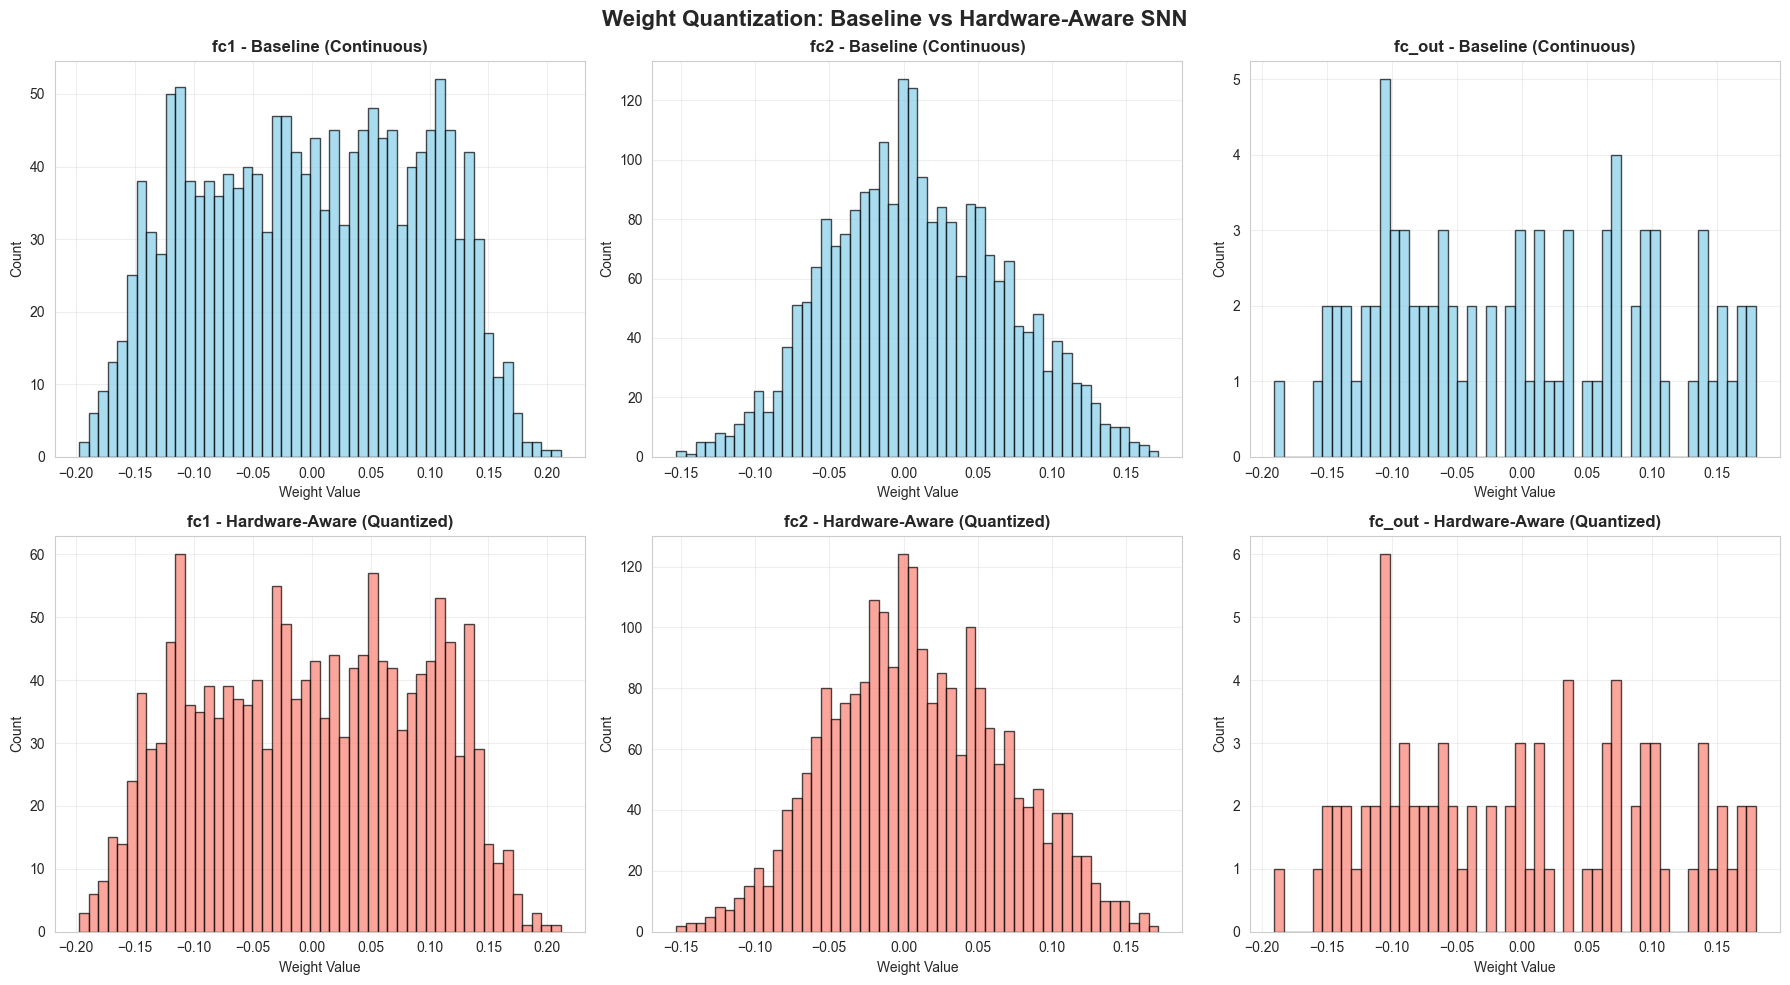


  WEIGHT QUANTIZATION STATISTICS

fc1:
  Baseline unique values: 1,568
  Hardware unique values: 232 (max: 256)
  Mean absolute error: 0.000397
  Max absolute error: 0.000802

fc2:
  Baseline unique values: 2,352
  Hardware unique values: 233 (max: 256)
  Mean absolute error: 0.000319
  Max absolute error: 0.000636

fc_out:
  Baseline unique values: 84
  Hardware unique values: 72 (max: 256)
  Mean absolute error: 0.000350
  Max absolute error: 0.000707


In [ ]:
# Visualize quantization effects for all layers
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, (layer_name, baseline_layer, hardware_layer) in enumerate([
    ('fc1', baseline_model.fc1, hardware_snn.snn.fc1),
    ('fc2', baseline_model.fc2, hardware_snn.snn.fc2),
    ('fc_out', baseline_model.fc_out, hardware_snn.snn.fc_out)
]):
    # Get weights
    baseline_w = baseline_layer.weight.detach().cpu().numpy().flatten()
    hardware_w = hardware_layer.weight.detach().cpu().numpy().flatten()
    
    # Plot 1: Baseline weights (continuous)
    axes[0, i].hist(baseline_w, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, i].set_title(f'{layer_name} - Baseline (Continuous)', fontsize=12, fontweight='bold')
    axes[0, i].set_xlabel('Weight Value')
    axes[0, i].set_ylabel('Count')
    axes[0, i].grid(True, alpha=0.3)
    
    # Plot 2: Hardware-aware weights (quantized)
    axes[1, i].hist(hardware_w, bins=50, color='salmon', edgecolor='black', alpha=0.7)
    axes[1, i].set_title(f'{layer_name} - Hardware-Aware (Quantized)', fontsize=12, fontweight='bold')
    axes[1, i].set_xlabel('Weight Value')
    axes[1, i].set_ylabel('Count')
    axes[1, i].grid(True, alpha=0.3)

plt.suptitle('Weight Quantization: Baseline vs Hardware-Aware SNN', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print quantization statistics

for layer_name, baseline_layer, hardware_layer in [
    ('fc1', baseline_model.fc1, hardware_snn.snn.fc1),
    ('fc2', baseline_model.fc2, hardware_snn.snn.fc2),
    ('fc_out', baseline_model.fc_out, hardware_snn.snn.fc_out)
]:
    baseline_w = baseline_layer.weight.detach().cpu().numpy().flatten()
    hardware_w = hardware_layer.weight.detach().cpu().numpy().flatten()
    
    print(f"\n{layer_name}:")
    print(f"  Baseline unique values: {len(np.unique(baseline_w)):,}")
    print(f"  Hardware unique values: {len(np.unique(hardware_w)):,} (max: {memristor_config['num_levels']})")
    print(f"  Mean absolute error: {np.abs(baseline_w - hardware_w).mean():.6f}")
    print(f"  Max absolute error: {np.abs(baseline_w - hardware_w).max():.6f}")

print(f"{'='*70}")

## 8. ROC-curve Baseline vs. Hardware

c:\Users\KSWes\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
c:\Users\KSWes\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


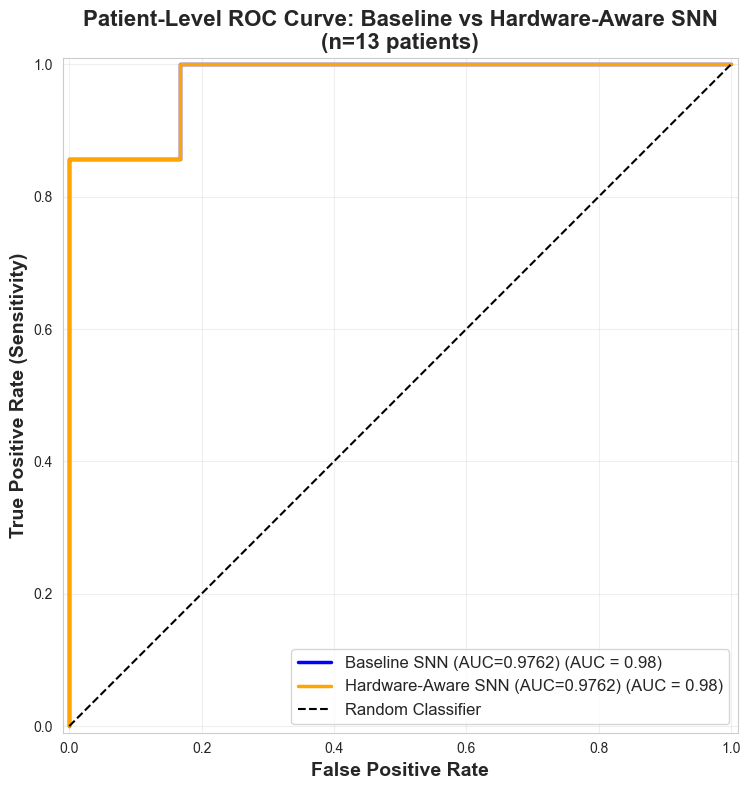


Patient-Level ROC Summary:
  Baseline AUC:  0.9762
  Hardware AUC:  0.9762
  Difference:    +0.0000


In [ ]:
# Plot Patient-Level ROC curves for both models
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10, 8))

# Baseline ROC (Patient-Level)
RocCurveDisplay.from_predictions(baseline_patient_labels, baseline_patient_scores, 
                                  name=f"Baseline SNN (AUC={baseline_patient_metrics['auc']:.4f})", 
                                  color='blue', ax=ax, linewidth=2.5)

# Hardware-aware ROC (Patient-Level)
RocCurveDisplay.from_predictions(hardware_patient_labels, hardware_patient_scores, 
                                  name=f"Hardware-Aware SNN (AUC={hardware_patient_metrics['auc']:.4f})", 
                                  color='orange', ax=ax, linewidth=2.5)

# Random classifier reference
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')

ax.set_title('Patient-Level ROC Curve: Baseline vs Hardware-Aware SNN\n(n=13 patients)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPatient-Level ROC Summary:")
print(f"  Baseline AUC:  {baseline_patient_metrics['auc']:.4f}")
print(f"  Hardware AUC:  {hardware_patient_metrics['auc']:.4f}")
print(f"  Difference:    {hardware_patient_metrics['auc'] - baseline_patient_metrics['auc']:+.4f}")

## 10. Save Results

In [13]:
# Prepare comprehensive results
results = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_architecture': {
        'type': 'Hardware-Aware SNN with Memristor Weight Quantization',
        'input_features': 28,
        'hidden1_size': 56,
        'hidden2_size': 42,
        'output_classes': 2,
        'num_steps': 35,
        'lif_beta': 0.9,
        'total_quantized_weights': total_memristors,
        'hardware_aware': True,
        'memtorch_used': False
    },
    'memristor_configuration': memristor_config,
    'baseline_performance': {k: float(v) for k, v in baseline_metrics.items()},
    'hardware_aware_performance': {k: float(v) for k, v in hardware_metrics.items()},
    'degradation': {
        'accuracy': float(hardware_metrics['accuracy'] - baseline_metrics['accuracy']),
        'sensitivity': float(hardware_metrics['sensitivity'] - baseline_metrics['sensitivity']),
        'specificity': float(hardware_metrics['specificity'] - baseline_metrics['specificity']),
        'f1_score': float(hardware_metrics['f1_score'] - baseline_metrics['f1_score']),
        'auc': float(hardware_metrics['auc'] - baseline_metrics['auc'])
    },
    'quantization_stats': {
        'fc1': {
            'baseline_unique_values': int(len(torch.unique(baseline_model.fc1.weight))),
            'hardware_unique_values': int(len(torch.unique(hardware_snn.snn.fc1.weight))),
            'quantization_error': float((baseline_model.fc1.weight - hardware_snn.snn.fc1.weight).abs().mean().item())
        },
        'fc2': {
            'baseline_unique_values': int(len(torch.unique(baseline_model.fc2.weight))),
            'hardware_unique_values': int(len(torch.unique(hardware_snn.snn.fc2.weight))),
            'quantization_error': float((baseline_model.fc2.weight - hardware_snn.snn.fc2.weight).abs().mean().item())
        },
        'fc_out': {
            'baseline_unique_values': int(len(torch.unique(baseline_model.fc_out.weight))),
            'hardware_unique_values': int(len(torch.unique(hardware_snn.snn.fc_out.weight))),
            'quantization_error': float((baseline_model.fc_out.weight - hardware_snn.snn.fc_out.weight).abs().mean().item())
        }
    }
}

# Save results
results_path = Path('results/snn')
results_path.mkdir(parents=True, exist_ok=True)

with open(results_path / 'hardware_aware_snn_results.json', 'w') as f:
    json.dump(results, f, indent=2)